
# From Attention to Transformers: A Deep Dive

#### Author: Debanjan Sengupta
Architect, Medidata Platform and Experience

Last Updated: May 2025

-- 🔥 🔥 Blitz 2025 🔥 🔥 --

*Learn fast, succeed faster*

#### Last Updated: July 2025

---

## Agenda

1. **What is a Transformer?** (why we needed it, and where it came from)
2. **How a Transformer Works** – the encoder, decoder, and the flow of data.
3. **Self-Attention in Detail** – math *and* intuition with ASCII diagrams.
4. **Types of Transformers** – encoder-only, decoder-only, encoder–decoder, encoder-decoder hybrids, etc.
5. **BERT vs GPT (deep dive)** – objectives, architecture, fine-tuning patterns, strengths/limits.
6. **Hands-on Academic Problem**  
   * Mini **extractive QA** fine‑tune with **BERT** (encoder-only).  
   * Mini **causal generation** demo with **GPT-2 small** (decoder-only).  
   * **Combination pipeline:** use BERT to extract an answer span, then feed the span & question context into GPT to produce a natural‑language explanation.
7. **Conclusion** – key takeaways, how the 2017 Google paper (*Attention Is All You Need*) ignited the LLM era, and where to go next.

> **Constraint:** Intentionally stay with *small* transformer models (BERT-base, GPT-2 small). No giant LLM fine-tunes here, which keeps things transparent and runnable in class.


## 0. Environment Setup

In [ ]:
# Uninstall potentially conflicting pre-installed packages to allow for a cleaner installation.
# Based on previous error outputs, these packages often cause dependency conflicts
# with the specific versions of transformers, accelerate, and torch required for this notebook.
!pip uninstall -y sentence-transformers torchvision fastai gradio gradio-client diffusers peft torchaudio

# Install necessary libraries for the notebook with versions known to be compatible with each other.
# - transformers: Provides access to pre-trained models, tokenizers, etc.
# - datasets: Offers easy access to various datasets, including SQuAD.
# - accelerate: Helps in distributed training and mixed precision.
# - evaluate: Provides metrics for evaluating model performance (like SQuAD metrics).
# - rouge-score: Needed for ROUGE metric (though not explicitly used for SQuAD here, good for generation tasks).
# - seqeval: Useful for sequence labeling tasks (like named entity recognition).
# - torch: The underlying deep learning framework (PyTorch).
# --upgrade: Ensures the latest versions of the libraries are installed.
# The specified versions are chosen to be compatible with each other and the datasets library needed for SQuAD,
# aiming for a stable installation after removing conflicting packages.
!pip install -q --upgrade transformers==4.39.3 accelerate==0.28.0 datasets==2.19.0 evaluate==0.4.1 rouge-score==0.1.2 seqeval==1.2.2 fsspec==2024.3.1 gcsfs==2024.3.1 torch

# This approach attempts to create a more isolated environment for the notebook's dependencies.

Found existing installation: sentence-transformers 4.1.0
Uninstalling sentence-transformers-4.1.0:
  Successfully uninstalled sentence-transformers-4.1.0
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: fastai 2.7.19
Uninstalling fastai-2.7.19:
  Successfully uninstalled fastai-2.7.19
Found existing installation: gradio 5.31.0
Uninstalling gradio-5.31.0:
  Successfully uninstalled gradio-5.31.0
Found existing installation: gradio_client 1.10.1
Uninstalling gradio_client-1.10.1:
  Successfully uninstalled gradio_client-1.10.1
Found existing installation: diffusers 0.34.0
Uninstalling diffusers-0.34.0:
  Successfully uninstalled diffusers-0.34.0
Found existing installation: peft 0.16.0
Uninstalling peft-0.16.0:
  Successfully uninstalled peft-0.16.0
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled t

In [ ]:
import os, random, math, numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
    AutoModelForQuestionAnswering, AutoModelForCausalLM,
    DataCollatorWithPadding, TrainingArguments, Trainer,
    default_data_collator
)
import evaluate
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda



---
## 1. What Is a Transformer?

A **Transformer** is a neural network architecture introduced in 2017 by Vaswani et al. in the paper *Attention Is All You Need*. It replaced recurrence (RNNs/LSTMs) and convolutions with a mechanism called **self-attention**, allowing models to look at **all tokens in a sequence at once** and learn relationships between them, regardless of distance.

### Why did we need something new?
Traditional sequence models had problems:
* **RNNs** process one token at a time → slow, and long-range dependencies fade (vanishing gradients).
* **CNNs** see local windows; deeper stacks needed for long context.
* **Parallelisation pain** – RNN time steps can't be parallelised easily.

**Transformers** solve this by:
* Computing token-to-token interactions in parallel.
* Using **positional encodings** to retain order.
* Scaling well to large data + distributed compute → foundation for modern large language models (LLMs).

---

### Quick ASCII Mental Model

```
Input Tokens:  [The] [movie] [was] [absolutely] [brilliant] [.]
                      |      |        |              |        |
                self-attention lets every token attend to every other token
```



---
## 2. How Does a Transformer Work? (Encoder–Decoder View)

The original Transformer has **two stacks**:

```
Input Embeddings + Positional Encoding
          │
      ┌───▼────┐
      │Encoder │  (repeated N times)
      └───▲────┘
          │  context vectors
          ▼
      ┌───▼────┐
      │Decoder │  (repeated N times)
      └───▲────┘
          │
   Output probabilities (next token)
```

### Encoder Block (one layer)
1. **Multi-Head Self-Attention** over the *input* tokens.
2. **Add & LayerNorm** residual connection.
3. **Positionwise Feed-Forward Network** (two linear layers + nonlinearity).
4. **Add & LayerNorm** again.

### Decoder Block (one layer)
1. **Masked Multi-Head Self-Attention** over previously generated tokens.
2. **Cross-Attention** over encoder outputs (so decoder can look at the source sequence).
3. FFN + residual + norms as in encoder.

We stack `N` layers (e.g., 6 in the original paper).

---

### Shape Cheat Sheet

| Symbol | Meaning | Shape (batch-first) |
|--------|---------|--------------------|
| *B* | batch size | — |
| *T* | sequence length | — |
| *d_model* | hidden width | e.g., 512 |
| *h* | # of heads | e.g., 8 |
| *d_k* | per-head key/query dim | d_model / h |

Self-attention takes `Q, K, V` tensors of shape `(B, T, d_model)` and returns `(B, T, d_model)`.



---
## 3. Self-Attention: Math + Intuition

### Scaled Dot-Product Attention (core equation)

Given **queries** Q, **keys** K, and **values** V:

\[
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^\top}{\sqrt{d_k}} + M \right) V
\]

* `QK^T` → similarity of each query to each key.  
* divide by \(\sqrt{d_k}\) → stabilise gradients when dimensions grow.  
* `M` (mask) → optional: block future tokens (decoder) or padded tokens.  
* softmax → attention weights per query row (sum to 1).  
* multiply by `V` → weighted sum of value vectors.

---

### ASCII attention heatmap idea

```
Query token: "brilliant"
Scores vs:   [The] [movie] [was] [absolutely] [brilliant] [.]
Weights:         .     .      .        *           ***       .
               (low) (low)  (low)    (med)        (high)   (low)
```

---

### Multi-Head Attention

Instead of doing this once with wide vectors, we **split the model width into multiple heads**:

```
Input d_model=512
 ├─ Head 1: 64-dim attention
 ├─ Head 2: 64-dim attention
 ...
 └─ Head 8: 64-dim attention
Concat → 512 → Linear projection
```

Why? Each head can specialise: syntax, coreference, positional offsets, etc.



---
## 4. Positional Encoding

Because self-attention is **order agnostic**, we inject position information.

### Sinusoidal (original paper)
For position *pos* and dimension *i*:

\[
PE_{pos,2i} = \sin(pos / 10000^{2i/d_{model}}) \\
PE_{pos,2i+1} = \cos(pos / 10000^{2i/d_{model}})
\]

These create smooth, continuous, wavelength‑scaled signals that generalise to unseen lengths.

### Learnable positional embeddings
Many modern models (BERT, GPT) learn position vectors instead of using sinusoids.




---
## 5. Types of Transformers

| Type | Examples | Directionality | Typical Use |
|------|----------|----------------|-------------|
| **Encoder‑only** | BERT, RoBERTa | Bidirectional (masked) | Classification, token tagging, QA (extractive) |
| **Decoder‑only** | GPT, GPT‑2, GPT‑Neo | Autoregressive (left→right) | Text generation, completion, instruction following |
| **Encoder–Decoder** | T5, BART, original Transformer | Seq2Seq: translation, summarization | Flexible input→output tasks |
| **Prefix / Prompt‑tuned variants** | T5 + adapters, GPT + prompts | Various | Parameter‑efficient transfer |
| **Vision Transformers (ViT)** | ViT, DeiT | Patch embeddings + encoder stack | Image classification |

We focus on **BERT (encoder-only)** and **GPT (decoder-only)** in this notebook.



---
## 6. BERT vs GPT – Deep Dive

### Training Objectives

| Aspect | **BERT** | **GPT** |
|--------|----------|---------|
| Pretraining task | Masked Language Modeling (MLM) + Next Sentence Prediction (NSP, original) | Causal Language Modeling (predict next token) |
| Context | **Bidirectional** – looks both left & right because masked tokens removed | **Unidirectional** – only left context (causal mask) |
| Output tokenization | WordPiece | Byte-Pair Encoding (BPE) (GPT-2 uses byte-level BPE) |
| Fine-tuning style | Add small head (classification, QA span) | Prompt with task text; fine-tune (if small) or in-context (large) |
| Strengths | Strong encodings, good for understanding | Fluent generation, long-form text |

---

### Visual

```
BERT (encoder-only)
Input: [CLS] the cat sat on the ____ [SEP]
Mask:              ^^^^
Model predicts masked token using both left & right context.

GPT (decoder-only)
Input: the cat sat on the
Model predicts next token step-by-step: "mat", "."
```



---
## 7. Hands-On: Academic Problem – Mini Extractive QA + Generation

We’ll do three things:

1. **BERT fine-tune** on a *tiny* SQuAD-style subset (extract answer span).
2. **GPT-2 small** generate answer text given question + context.
3. **Hybrid pipeline**: Use BERT to fetch the answer span, then ask GPT to produce a natural language explanation sentence that includes the span.

**Note:** With tiny subsets and few epochs, metrics will be noisy. This is a *teaching* run.


In [ ]:
# Load the full SQuAD dataset from the datasets library.
# SQuAD (Stanford Question Answering Dataset) is a reading comprehension dataset.
from datasets import load_dataset

# Load the full SQuAD dataset.
# This dataset includes training and validation splits for Question Answering.
full_squad_dataset = load_dataset('squad')

# Display the full dataset dictionary to show its structure and sizes.
full_squad_dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

### 7.1 Tokenizer & preprocessing for BERT QA

In [ ]:
bert_model_ckpt = 'bert-base-uncased'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_ckpt)

max_length = 384
doc_stride = 128

def preprocess_training_examples(examples):
    """
    Preprocesses the training examples for question answering.

    Args:
        examples (dict): A dictionary containing the training examples with
                         'question', 'context', and 'answers' keys.

    Returns:
        transformers.tokenization_utils_base.BatchEncoding: Tokenized inputs
        with start and end positions for the answers.
    """
    questions = [q.strip() for q in examples['question']]
    inputs = bert_tokenizer(
        questions,
        examples['context'],
        max_length=max_length,
        truncation='only_second', # Truncate only the context if combined length exceeds max_length
        stride=doc_stride, # Use a sliding window to handle long contexts
        return_overflowing_tokens=True, # Return a mapping from new features to original samples
        return_offsets_mapping=True, # Return character spans for each token
        padding='max_length' # Pad sequences to max_length
    )

    sample_mapping = inputs.pop('overflow_to_sample_mapping')
    offset_mapping = inputs.pop('offset_mapping')
    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = inputs['input_ids'][i]
        # Find the index of the CLS token, which is used as a default answer position
        # when the answer is not found in the truncated context.
        cls_index = input_ids.index(bert_tokenizer.cls_token_id)

        # Get the original sample index for this feature (due to truncation and stride)
        sample_idx = sample_mapping[i]
        # Get the answer information for the original sample
        answer = examples['answers'][sample_idx]
        # If there is no answer provided for this example, default to the CLS token
        if len(answer['answer_start']) == 0:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
            continue

        # Get the character start and end positions of the answer in the original context
        start_char = answer['answer_start'][0]
        end_char   = start_char + len(answer['text'][0])
        # Get the sequence IDs to distinguish between question (0), context (1), and special tokens (None)
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end token indices of the context in the tokenized sequence
        idx = 0
        while sequence_ids[idx] != 1: idx += 1
        context_start = idx
        while sequence_ids[idx] == 1: idx += 1
        context_end = idx - 1

        # If the answer is not fully contained within the context part of this feature,
        # default the answer positions to the CLS token.
        if not (offsets[context_start][0] <= start_char and offsets[context_end][1] >= end_char):
            start_positions.append(cls_index); end_positions.append(cls_index)
            continue

        # Otherwise, find the start and end token indices of the answer within the context
        # part of the tokenized sequence.
        start_token = context_start
        while start_token <= context_end and offsets[start_token][0] <= start_char:
            start_token += 1
        start_token -= 1

        end_token = context_end
        while end_token >= context_start and offsets[end_token][1] >= end_char:
            end_token -= 1
        end_token += 1

        # Append the found start and end token indices
        start_positions.append(start_token)
        end_positions.append(end_token)

    # Add the computed start and end positions to the inputs dictionary
    inputs['start_positions'] = start_positions
    inputs['end_positions']   = end_positions
    return inputs

def preprocess_validation_examples(examples):
    """
    Preprocesses the validation examples for question answering.

    Args:
        examples (dict): A dictionary containing the validation examples with
                         'question', 'context', and 'id' keys.

    Returns:
        transformers.tokenization_utils_base.BatchEncoding: Tokenized inputs
        with example IDs and offset mappings adjusted for context only.
    """
    questions = [q.strip() for q in examples['question']]
    inputs = bert_tokenizer(
        questions,
        examples['context'],
        max_length=max_length,
        truncation='only_second', # Truncate only the context
        stride=doc_stride, # Use a sliding window for long contexts
        return_overflowing_tokens=True, # Return a mapping from new features to original samples
        return_offsets_mapping=True, # Return character spans for each token
        padding='max_length' # Pad sequences to max_length
    )

    sample_mapping = inputs.pop('overflow_to_sample_mapping')
    example_ids = []

    for i in range(len(inputs['input_ids'])):
        # Get the original example ID for this feature
        sample_idx = sample_mapping[i]
        example_ids.append(examples['id'][sample_idx])
        # Get the sequence IDs to distinguish between question (0), context (1), and special tokens (None)
        sequence_ids = inputs.sequence_ids(i)
        offset = inputs['offset_mapping'][i]
        # Set the offset mapping to None for question tokens and special tokens,
        # keeping it only for context tokens.
        inputs['offset_mapping'][i] = [o if sequence_ids[k] == 1 else None for k,o in enumerate(offset)]

    # Add the original example IDs to the inputs dictionary
    inputs['example_id'] = example_ids
    return inputs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_qa = full_squad_dataset['train'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=full_squad_dataset['train'].column_names
)

val_qa = full_squad_dataset['validation'].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=full_squad_dataset['validation'].column_names
)
train_qa, val_qa

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

(Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
     num_rows: 88524
 }),
 Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
     num_rows: 10784
 }))

### 7.2 Fine-tune BERT for QA

In [ ]:
bert_qa_model = AutoModelForQuestionAnswering.from_pretrained(bert_model_ckpt).to(device)

data_collator = default_data_collator

args = TrainingArguments(
    output_dir='./bert-qa-demo', # Directory to save model checkpoints and logs
    evaluation_strategy='steps', # Evaluate model every `eval_steps`
    eval_steps=200, # Number of steps between evaluations (keep for monitoring progress)
    save_steps=200, # Number of steps between saving model checkpoints (keep for saving progress)
    logging_steps=50, # Number of steps between logging training progress
    per_device_train_batch_size=16, # Increased batch size to leverage A100 memory
    per_device_eval_batch_size=16, # Increased batch size for evaluation
    num_train_epochs=3, # Slightly increased epochs, can increase further with larger dataset
    learning_rate=3e-5, # Keep learning rate, can tune if needed
    weight_decay=0.01, # Keep weight decay
    fp16=True, # Enable mixed precision training for faster training on A100
    report_to='none' # Disable reporting to external services like Weights & Biases
)

trainer = Trainer(
    model=bert_qa_model, # The model to train
    args=args, # Training arguments
    train_dataset=train_qa, # Training dataset
    eval_dataset=val_qa, # Evaluation dataset
    tokenizer=bert_tokenizer, # The tokenizer used for preprocessing
    data_collator=data_collator # Function to collate samples into batches
)

trainer.train() # Start the training process

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scale

Step,Training Loss,Validation Loss
200,2.132800,No log
400,1.598700,No log
600,1.480800,No log
800,1.437700,No log
1000,1.328300,No log
1200,1.364100,No log
1400,1.284200,No log
1600,1.290400,No log
1800,1.236200,No log
2000,1.215800,No log


TrainOutput(global_step=16599, training_loss=0.8339256733840859, metrics={'train_runtime': 3331.2868, 'train_samples_per_second': 79.721, 'train_steps_per_second': 4.983, 'total_flos': 5.204482670991974e+16, 'train_loss': 0.8339256733840859, 'epoch': 3.0})

### 7.3 Evaluate BERT QA (SQuAD metrics)

In [ ]:
import evaluate
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

!mkdir -p local_squad_v2
!wget -q https://raw.githubusercontent.com/huggingface/evaluate/main/metrics/squad_v2/squad_v2.py      -O local_squad_v2/squad_v2.py
!wget -q https://raw.githubusercontent.com/huggingface/evaluate/main/metrics/squad_v2/compute_score.py -O local_squad_v2/compute_score.py

# 2️⃣  Point evaluate at the DIRECTORY (not the .py file)
import evaluate
qa_metric = evaluate.load("/content/local_squad_v2")   # <- path ends with folder name

def postprocess_qa_predictions(examples, features, raw_predictions, n_best=20, max_answer_length=30):
    # Adapted from HF example util
    all_start, all_end = raw_predictions
    example_id_to_index = {k:i for i,k in enumerate(examples['id'])}
    features_per_example = {}
    for i, feat_id in enumerate(features['example_id']):
        features_per_example.setdefault(feat_id, []).append(i)

    predictions = {}

    def process_example(example_id, feature_indices):
        context = examples['context'][example_id_to_index[example_id]]
        offset_mapping = [features['offset_mapping'][i] for i in feature_indices]
        start_logits = [all_start[i] for i in feature_indices]
        end_logits   = [all_end[i] for i in feature_indices]

        prelim = []
        for feat_idx, (start_logit, end_logit, offsets) in enumerate(zip(start_logits, end_logits, offset_mapping)):
            start_indexes = np.argsort(start_logit)[-n_best:]
            end_indexes   = np.argsort(end_logit)[-n_best:]
            for s in start_indexes:
                for e in end_indexes:
                    if e < s: continue
                    if e - s + 1 > max_answer_length: continue
                    if offsets[s] is None or offsets[e] is None: continue
                    start_char = offsets[s][0]; end_char = offsets[e][1]
                    text = context[start_char:end_char]
                    score = start_logit[s] + end_logit[e]
                    prelim.append((score, text))
        if len(prelim)==0:
            return example_id, ""
        else:
            return example_id, sorted(prelim, key=lambda x:x[0], reverse=True)[0][1]

    # Use ThreadPoolExecutor for parallel processing
    # The number of workers can be adjusted based on the number of available CPU cores
    # Using a higher number than physical cores might help with I/O bound tasks, but
    # for CPU-bound tasks like this, the number of workers should ideally be <= number of cores.
    # We'll use a reasonable default, you can adjust this number.
    num_workers = 8 # You can adjust this number based on your runtime's CPU cores

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Submit tasks for each example
        future_to_example = {executor.submit(process_example, example_id, feature_indices): example_id
                             for example_id, feature_indices in features_per_example.items()}

        # Collect results as they complete
        for future in as_completed(future_to_example):
            example_id, prediction_text = future.result()
            predictions[example_id] = prediction_text

    return predictions

preds = trainer.predict(val_qa)
# Corrected variable name from squad_small to full_squad_dataset
val_examples = full_squad_dataset['validation']
val_features = val_qa
final_preds = postprocess_qa_predictions(val_examples, val_features, preds.predictions)

references = [{'id': ex['id'], 'answers': ex['answers']} for ex in val_examples]
result = qa_metric.compute(predictions=[{'id':k,'prediction_text':v} for k,v in final_preds.items()],
                           references=references)
result

* * *
## Using the Fine-tuned BERT QA Model for Inference

Now that we have fine-tuned the BERT model on the SQuAD dataset, we can use it to answer questions given a context. The model outputs logits for the start and end positions of the answer span within the context. We then select the span with the highest combined start and end logits as the predicted answer.

In [ ]:
# Example of using the fine-tuned BERT QA model for inference

# Select a few samples from the validation dataset to test the model
sample_indices = range(5) # Process the first 5 examples

for sample_idx in sample_indices:
    sample = full_squad_dataset['validation'][sample_idx]

    question = sample['question']
    context = sample['context']
    true_answers = sample['answers']['text']

    print(f"--- Example {sample_idx + 1} ---")
    print(f"Question: {question}")
    print(f"Context: {context[:500]}...") # Print a truncated context for readability
    print(f"True Answers: {true_answers}")

    # Tokenize the question and context
    inputs = bert_tokenizer(question, context, return_tensors='pt',
                            max_length=max_length, truncation='only_second', padding='max_length',
                            return_offsets_mapping=True).to(device)

    # Get the model's predictions (start and end logits)
    with torch.no_grad():
        # Remove offset_mapping from inputs as the model does not accept it
        outputs = bert_qa_model(**{k: v for k, v in inputs.items() if k != 'offset_mapping'})

    # Get the predicted start and end token indices
    start_idx = torch.argmax(outputs.start_logits, dim=-1).item()
    end_idx = torch.argmax(outputs.end_logits, dim=-1).item()

    # Convert the token indices back to the answer span string
    # Need to handle potential issues with start/end indices being out of bounds or reversed
    predicted_answer = ""
    if start_idx <= end_idx:
        # Get the character offsets for the predicted span
        offset_mapping = inputs['offset_mapping'][0]
        # Ensure the predicted span is within the context part (token_type_ids == 1)
        sequence_ids = inputs.sequence_ids(0)

        # Find the start and end token indices of the context
        context_start_token = -1
        context_end_token = -1
        for i, seq_id in enumerate(sequence_ids):
            if seq_id == 1:
                if context_start_token == -1:
                    context_start_token = i
                context_end_token = i

        # Check if the predicted span is within the context tokens
        if start_idx >= context_start_token and end_idx <= context_end_token:
            start_char = offset_mapping[start_idx][0]
            end_char = offset_mapping[end_idx][1]
            predicted_answer = context[start_char:end_char]
        else:
             predicted_answer = "Could not extract answer from context."


    print(f"Predicted Answer: {predicted_answer}\n")

--- Example 1 ---
Question: Which NFL team represented the AFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniv...
True Answers: ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']
Predicted Answer: Denver Broncos

--- Example 2 ---
Question: Which NFL team represented the NFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National

* * *
## Deep Dive: How BERT Works (Detailed Breakdown)

BERT (Bidirectional Encoder Representations from Transformers) is a powerful pre-trained model based on the **encoder** part of the original Transformer architecture. Its primary purpose is to generate rich, contextualized representations (numerical vectors) for every token in an input sequence. It reads the *entire* input simultaneously to understand the context from both directions (left-to-right and right-to-left).

Think of it as a sophisticated system that takes a sentence and produces a set of enhanced feature vectors, one for each word, where each vector captures the word's meaning in the specific context of that sentence.

Here’s a detailed breakdown of the architecture:

### Overall Structure

BERT consists of an **Input Embedding Layer** followed by a stack of identical **Encoder Layers**. The number of Encoder Layers varies depending on the specific BERT model (e.g., BERT-base has 12 layers, BERT-large has 24).

### The BERT Encoder Layer (One Layer)

BERT is built by stacking multiple identical Encoder layers. Each layer refines the representation of the input tokens. Let's look at the components *inside* a single Encoder layer:

1. **Multi-Head Self-Attention:** This is the core mechanism. For each token in the input sequence, this layer calculates how much it should "pay attention" to every other token in the *same* sequence. This is done in parallel across multiple "heads".

   * **Queries (Q), Keys (K), Values (V):** The input vector for each token is linearly transformed into three different vectors: a Query, a Key, and a Value.
     * **Query:** Like asking, "What information am I looking for?"
     * **Key:** Like an index, saying, "What information do I have?"
     * **Value:** The actual information to be retrieved/weighted.
   * **Calculating Attention Scores:** For each token's Query, it's compared (using a dot product) with every other token's Key. This gives a score indicating how relevant each other token is to the current token.
   * **Scaling:** The scores are divided by the square root of the dimension of the Keys ($ \sqrt{d_k} $). This prevents the dot products from becoming too large, which can lead to unstable gradients during training (softmax would become very sharp).
   * **Masking (Implicit for BERT):** Although the original Transformer Decoder uses masking to prevent looking at future tokens, the BERT *Encoder* uses attention over the *entire* sequence (bidirectional). There's a form of masking applied during *pre-training* (Masked Language Modeling) but within the self-attention block itself, a token attends to all other tokens including those before and after it. Padding tokens are also typically masked to prevent them from being attended to or attending to others.
   * **Softmax:** The scaled scores are passed through a softmax function. This converts the scores into attention weights that sum up to 1 for each token's Query. These weights determine how much "value" each other token contributes to the current token's new representation.
   * **Weighted Sum of Values:** Each token's Value vector is multiplied by its corresponding attention weight. These weighted Value vectors are then summed up. This results in a new vector for the original token that is a weighted combination of *all* the Value vectors in the sequence, effectively incorporating context from the entire input based on the calculated attention weights.
   * **Multi-Head:** Instead of doing this once with the full input vector dimension, the input is split into multiple "heads". Each head performs the attention calculation independently on a lower-dimensional projection of the input. The results from all heads are then concatenated and linearly transformed back to the original input dimension. This allows the model to jointly attend to information from different representation subspaces at different positions, capturing diverse types of relationships (e.g., one head might focus on syntax, another on coreference).

### Inside One BERT Encoder Layer (Detailed Flow)

After the Input Embeddings (which provided the initial vectors for each token), these vectors pass through a stack of Encoder layers. Each layer performs the following sequence of operations:

1. **Add & Layer Normalization (Post-Attention):**
   * **"Add" (Residual Connection):** The input to the Multi-Head Self-Attention layer is **added** to the output of the Multi-Head Self-Attention layer. This is called a "residual connection" (like in ResNet architectures). It helps the gradients flow more easily through the network during training, especially in deep models, by providing a shortcut connection.
   * **Layer Normalization:** This normalizes the sum of the input and the attention output *across the features* for each *individual* token. Unlike Batch Normalization (which normalizes across the batch for each feature), Layer Normalization is independent of the batch size and works well for variable-length sequences. It helps stabilize training by keeping the inputs to the next sub-layer within a similar distribution. The formula is roughly:

     $$
\text{LayerNorm}(x) = \gamma \odot \frac{x - \text{mean}(x)}{\sqrt{\text{variance}(x) + \epsilon}} + \beta
$$

     Where $ \gamma $ and $ \beta $ are learned scaling and shifting parameters, and $ \epsilon $ is a small number for numerical stability.
   * **Combined Step:** So, the sequence is: Input → Multi-Head Self-Attention → (Add Input + Attention Output) → Layer Normalization.
2. **Position-wise Feed-Forward Network:** This is a simple, fully connected feed-forward network that is applied to **each position (token)** independently and identically. It consists of two linear transformations with a ReLU activation in between.

   * *Shape Transformation:* If the input vector for a token has dimension *d_model*, the first linear layer typically expands this to a higher dimension (e.g., 4 * d_model), applies the ReLU activation, and then the second linear layer projects it back down to the original *d_model* dimension.

   $$
\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
$$

   Where $ W_1, b_1, W_2, b_2 $ are learned parameters.

   * *Purpose:* While self-attention allows interaction between tokens, the feed-forward network allows the model to process the information for each token position independently. It adds non-linearity and further transforms the representations.

### Detailed Text Diagram of One BERT Encoder Layer

Here is a text diagram illustrating the flow of data through a single BERT Encoder layer:

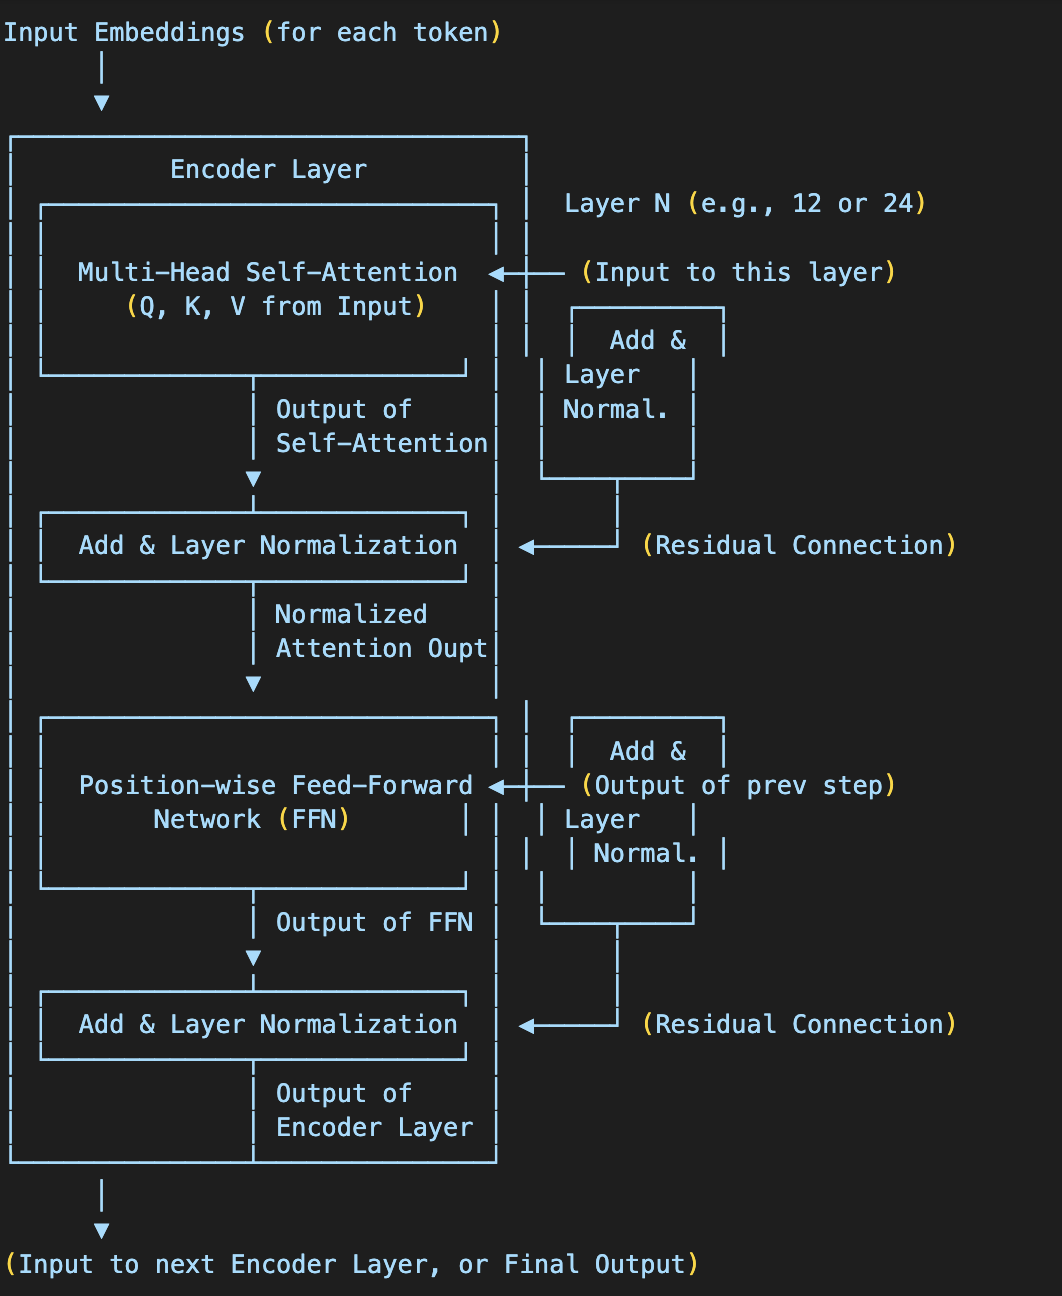


### Conclusion on BERT

In conclusion, BERT is a powerful **encoder-only** Transformer model primarily designed for **understanding** text. By using the **Masked Language Modeling** pre-training objective and processing input bidirectionally through its stacked **Encoder layers** with **Multi-Head Self-Attention**, BERT learns deep, contextualized representations for every token. These representations capture how a word's meaning is influenced by all other words in the input sequence.

Unlike decoder-only models that generate text, BERT excels at tasks requiring a nuanced understanding of the entire input, such as classification, sentiment analysis, named entity recognition, and extractive question answering (where the answer is a span of text within the input). Its architecture allows for efficient parallel processing and scales well, making it a foundational model for many downstream NLP applications focused on text comprehension.


---
## 7.4 GPT-2 Small: Causal Generation Demo

We now load a small GPT‑2 model and show:
* Next‑token generation.
* Constrained generation using a question + extracted document snippet.

We will **not** fine-tune GPT-2 (to keep runtime light); we simply *prompt* it.


In [ ]:
gpt_ckpt = 'gpt2'
gpt_tokenizer = AutoTokenizer.from_pretrained(gpt_ckpt)
gpt_model = AutoModelForCausalLM.from_pretrained(gpt_ckpt).to(device)

def gpt_generate(prompt, max_new_tokens=600, temperature=0.8, top_k=50):
    """
    Generates text using the loaded GPT-2 model.

    Args:
        prompt (str): The initial text prompt for generation.
        max_new_tokens (int, optional): The maximum number of new tokens to generate. Defaults to 60.
        temperature (float, optional): Controls the randomness of the generation. Higher values
                                       result in more random outputs. Defaults to 0.8.
        top_k (int, optional): The number of highest probability vocabulary tokens to keep
                                for top-k-filtering. Defaults to 50.

    Returns:
        str: The generated text, excluding special tokens.
    """
    inputs = gpt_tokenizer(prompt, return_tensors='pt').to(device)
    outputs = gpt_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_k=top_k,
        do_sample=True, # Enable sampling
        pad_token_id=gpt_tokenizer.eos_token_id # Use EOS token for padding
    )
    return gpt_tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example usage: Generate text based on a prompt about attention in neural networks.
print(gpt_generate("In neural networks, attention allows", 400))

In neural networks, attention allows us to focus on the task at hand. The second task is to control attention, but the third task is to work with the brain and the process needs to be optimized so that the task can be executed in a more efficient fashion. This is often accomplished through the use of more sophisticated machine learning techniques, like the deep learning technique called RNNs and deep learning methods called TensorFlow.

These neural networks can be developed using a variety of approaches, from highly structured systems, to highly heterogeneous systems with large number of data sets. The following diagram shows a simple neural network that can be developed using a number of different approaches, depending on the type of data set, the task for which it is working, and the task it is learning.

Figure 10. Neural networks for developing a simple, robust neural network using RNNs. The gray matter in the center of the image is shown over a larger red color background.

Now t


---
## 7.5 Hybrid Pipeline: BERT Extracts, GPT Explains

Workflow:
1. Feed *question + context* into fine‑tuned BERT QA → extract short answer span.
2. Build a natural language prompt:  
   `"Question: ... Answer: <span>. Explanation:"`
3. Let GPT-2 generate a friendly explanation that includes the span.

This mirrors real production stacks: **understanding model** + **generation model**.


In [ ]:
def answer_with_bert(question, context):
    """
    Uses the fine-tuned BERT QA model to extract an answer span from the context
    for a given question.

    Args:
        question (str): The question string.
        context (str): The context string where the answer is expected to be found.

    Returns:
        str: The extracted answer span from the context, or an empty string if
             no valid answer is found.
    """
    inputs = bert_tokenizer(question, context, return_tensors='pt',
                            max_length=384, truncation='only_second', padding='max_length').to(device)
    with torch.no_grad():
        outputs = bert_qa_model(**inputs)
    start = torch.argmax(outputs.start_logits, dim=-1).item()
    end   = torch.argmax(outputs.end_logits, dim=-1).item()
    # convert to char span
    tokens = inputs['input_ids'][0]
    offset_mapping = bert_tokenizer(question, context, return_offsets_mapping=True,
                                    max_length=384, truncation='only_second', padding='max_length')['offset_mapping']
    # Find token segment that maps to context
    sequence_ids = bert_tokenizer(question, context, max_length=384, truncation='only_second', padding='max_length').sequence_ids()
    context_start = sequence_ids.index(1)
    context_end = len(sequence_ids) - 1 - sequence_ids[::-1].index(1)

    if start < context_start or end > context_end or start > end:
        return ""
    start_char, _ = offset_mapping[start]
    _, end_char   = offset_mapping[end]
    return context[start_char:end_char]

def gpt_explain(question, context, answer):
    """
    Generates a natural language explanation using the GPT-2 model based on a
    question, context, and an extracted answer.

    Args:
        question (str): The question string.
        context (str): The context string used for answering.
        answer (str): The extracted answer span from the context.

    Returns:
        str: The generated explanation text.
    """
    prompt = f"Question: {question}\nAnswer: {answer}\nContext excerpt: {context[:300]}\nExplanation:"
    return gpt_generate(prompt, max_new_tokens=80, temperature=0.7)

# Try one example
sample = full_squad_dataset['validation'][0]
ans = answer_with_bert(sample['question'], sample['context'])
print('Q:', sample['question'])
print('BERT answer:', ans)
print('GPT explanation:', gpt_explain(sample['question'], sample['context'], ans))

Q: Which NFL team represented the AFC at Super Bowl 50?
BERT answer: Denver Broncos
GPT explanation: Question: Which NFL team represented the AFC at Super Bowl 50?
Answer: Denver Broncos
Context excerpt: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super B
Explanation: The game was played on Super Bowl Sunday, September 11, 2015, at Wells Fargo Center in New York City. The AFC champion Cleveland Browns defeated the National Football League's Carolina Panthers 24–10 to earn their third Super B
The NFC champion Denver Broncos defeated the National Football League's Carolina Panthers 24–10 to earn their third Super B
The AFC's champions Denver Broncos defeated the National Football League



---
## 8. Conclusion & Where to Go Next

### Key Takeaways
* **Self-attention** lets every token contextualize itself relative to every other token in *one* parallel operation.
* **Transformers scale** — training stability + data parallelism produced today’s large language models (LLMs).
* **BERT vs GPT** reflects a split between understanding (bidirectional encoders) and generation (autoregressive decoders). Both grew into families.
* Combining models (like we did with BERT extract + GPT explain) is common in production: *understand → generate*.

---

### Read the Originals
* Vaswani et al. (2017). *Attention Is All You Need*. arXiv:1706.03762.
* Devlin et al. (2018). *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding*. arXiv:1810.04805.
* Radford et al. (2018). *Improving Language Understanding by Generative Pre-Training* (GPT).
* Radford et al. (2019). *Language Models are Unsupervised Multitask Learners* (GPT-2 Technical Report).

---

### Pathways Toward LLMs
1. **Scale depth & width** (more layers, bigger hidden size).
2. **Scale data** (web-scale corpora, deduplication, multilingual sources).
3. **Training tricks** – mixed precision, gradient checkpointing, distributed data/FSDP.
4. **Instruction tuning & RLHF** – align generation with human intent.
5. **Tool use & agents** – Transformers become components in interactive, multi‑tool systems.

---
